In [ ]:
from google.colab import drive
from importlib import reload

import matplotlib.pyplot as plt
import pandas as pd

import warnings
import datetime
import math

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Pадача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

# План работы
1) Получение данных

2) Предобработка данных

3) Добавление новых параметров

4) Исследовательский анализ данных

5) Вывод

### Откроем файл с данными и изучим общую информацию.

In [ ]:
#Получение данных
data = pd.read_csv('/content/drive/MyDrive/real_estate_data.csv', sep="\t", decimal='.')
total_length = len(data)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

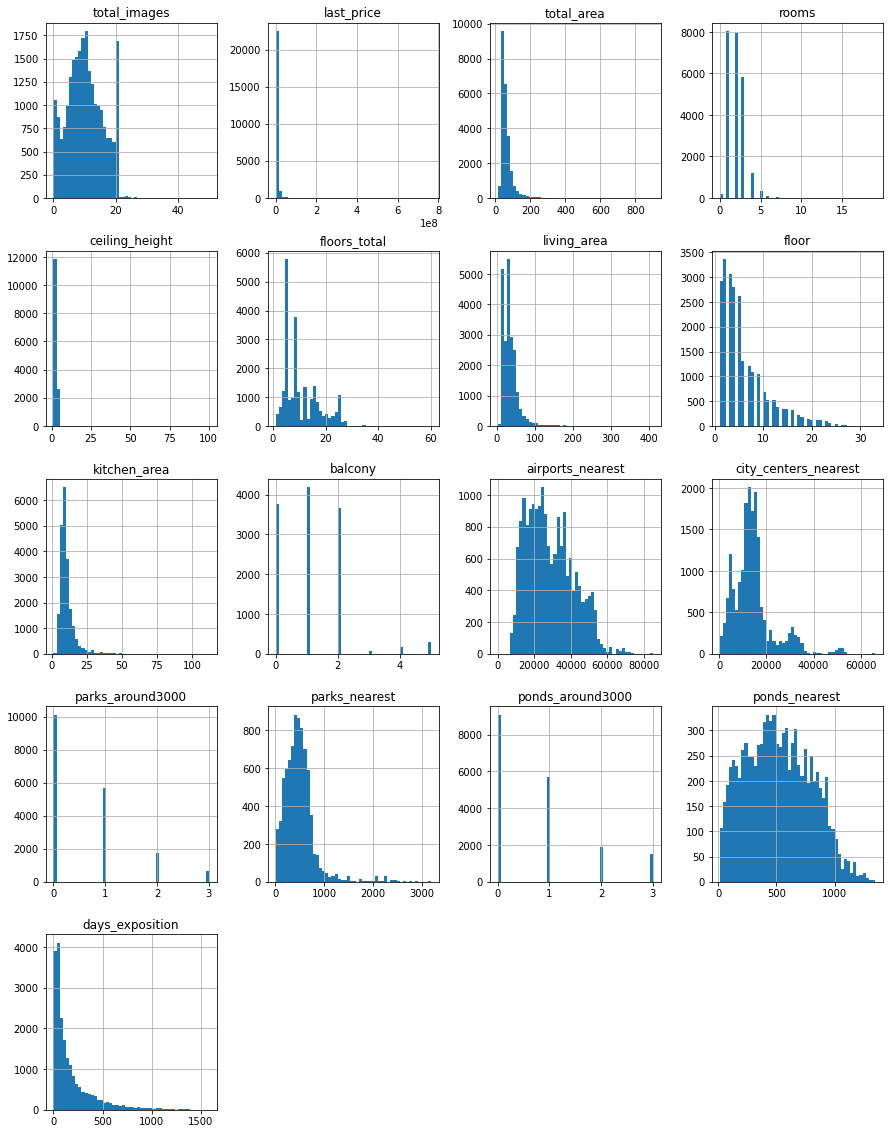

In [ ]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'})
data.hist(figsize=(15,20), bins=50);

Вывод: В ходе данного пункта, при попытке открытия файлв методом read_csv без парамметра sep значения не разделились на столбцы. Из быстрого осмотра данных и названий столбцов стало понятно, что необходимо указать параметр sep='\t' и десятичный разделитель decimal='.'. При оценке общей информации о датафрейме оказалось, что название одного из столбцов выбивается из общей стиля, поэтому было заменено: cityCenters_nearest -> city_centers_nearest. Также в данном пункте были сделаны выводы о количестве пропущенных значений и построены гистограммы для каждого столбца датафрейма.

### Предобработка данных

#### Заполнение пропусков в столбцах

Пропуски в столбца можно объяснить человеческим и техническим факторами. Рассмотрим возможные причины, обусловленные человеческим фактором.

Пропуски в столбцах 'is_apartment' и 'balcony' можно объяснить тем, что квартира не является апартаментами и балконы в ней отсутствуют, поэтому составитель объявления просто проигнорировал заполненние этих данных. Пропуски в прочих столбцах могут быть объяснены тем, что заявитель вводил только основные данные, пропуская уточняющие.

Говоря о технических факторах в первую очередь необходимо сказать об отсутсвии проверки на обязательное заполнение всех полей заявления. Также заявитель мог ввести данные в некорректной форме, которые затем были отброшены при обработке. Данные могли исказиться на этапах объединения таблиц, выгрузки и загрузки, а также при отправлении неверных запросов к БД.

In [ ]:
#возвращает коэффициент вариации
def cv(col):
    return col[0] / col[1]

#составим описательную статитстику по данным для последующего сравнения с заполнеными пропусками
stat = data.select_dtypes(include=['int64', 'float64']).apply(['std', 'mean', 'min', 'median', 'max'])
stat.loc[len(stat.index)] = stat.apply(cv, axis=0)
stat = stat.rename(index={5:'cv'})

In [ ]:
#возращает медианное значение жилой площади для квартир с тем же колчеством комнат и балконов
def median_living_area(line):
    if pd.isna(line['living_area']):
        new_data = (data[(data['rooms'] == line['rooms']) &
                         (data['balcony'] == line['balcony']) &
                         ~(pd.isna(data['living_area']))]
                   )
        return new_data['living_area'].median()
    return line['living_area']

#возращает медианное значение площади кухни для квартир с тем же колчеством комнат и балконов
def median_kitchen_area(line):
    if pd.isna(line['kitchen_area']):
        new_data = (data[(data['rooms'] == line['rooms']) &
                         (data['balcony'] == line['balcony']) &
                         ~(pd.isna(data['kitchen_area']))]
                   )
        return new_data['kitchen_area'].median()
    return line['kitchen_area']

In [ ]:
#заполнение пропусков
data[['is_apartment', 'balcony', 'parks_around3000', 'ponds_around3000']] = (
    data[['is_apartment', 'balcony', 'parks_around3000', 'ponds_around3000']].fillna(0)
)
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())
data['living_area'] = data.apply(median_living_area, axis=1)
data['kitchen_area'] = data.apply(median_kitchen_area, axis=1)
data['locality_name'] = data['locality_name'].fillna('Другое')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,0,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,0,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,0,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,45.0,9,0,...,9.4,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,0,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Для выбора необходимых типов данных оценивались диапазон и возможные значения этих данных. Так, столбец 'is_apartment'принимает только 2 значения (0/1), а следовательно должен быть преобразован в тип данных bool. Количество этажей и балконов исчисляется целыми положительными числами, поэтому можно установить тип данных int. Для даты публикации заявления существует свой тип данных datetime.

In [ ]:
#Преобразование типов данных
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['floors_total'] = data['floors_total'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['balcony'] = data['balcony'].astype('int')
#data.info()

In [ ]:
#Проверка изменения статистических данных
filled_stat = data.select_dtypes(include=['int64', 'float64']).apply(['std', 'mean', 'min', 'median', 'max'])
filled_stat.loc[len(filled_stat.index)] = filled_stat.apply(cv, axis=0)
filled_stat = filled_stat.rename(index={5:'cv'})
full_stat = (
    stat.merge(filled_stat, left_index=True, right_index=True, suffixes=('_af', '_pf'))
    .sort_index(axis=1)
)
full_stat.style.format("{:,.2f}")

,airports_nearest_af,airports_nearest_pf,balcony_af,balcony_pf,ceiling_height_af,ceiling_height_pf,city_centers_nearest_af,city_centers_nearest_pf,days_exposition_af,days_exposition_pf,floor_af,floor_pf,floors_total_af,floors_total_pf,kitchen_area_af,kitchen_area_pf,last_price_af,last_price_pf,living_area_af,living_area_pf,parks_around3000_af,parks_around3000_pf,parks_nearest_af,parks_nearest_pf,ponds_around3000_af,ponds_around3000_pf,ponds_nearest_af,ponds_nearest_pf,rooms_af,rooms_pf,total_area_af,total_area_pf,total_images_af,total_images_pf
std,"12,630.88","12,630.88",1.07,0.96,1.26,0.99,"8,608.39","8,608.39",219.73,219.73,4.89,4.89,6.60,6.59,5.91,5.67,"10,887,013.27","10,887,013.27",22.03,21.70,0.80,0.75,342.32,342.32,0.94,0.88,277.72,277.72,1.08,1.08,35.65,35.65,5.68,5.68
mean,"28,793.67","28,793.67",1.15,0.59,2.77,2.72,"14,191.28","14,191.28",180.89,180.89,5.89,5.89,10.67,10.67,10.57,10.46,"6,541,548.77","6,541,548.77",34.46,34.32,0.61,0.47,490.80,490.80,0.77,0.59,517.98,517.98,2.07,2.07,60.35,60.35,9.86,9.86
min,0.00,0.00,0.00,0.00,1.00,1.00,181.00,181.00,1.00,1.00,1.00,1.00,1.00,1.00,1.30,1.30,"12,190.00","12,190.00",2.00,2.00,0.00,0.00,1.00,1.00,0.00,0.00,13.00,13.00,0.00,0.00,12.00,12.00,0.00,0.00
median,"26,726.00","26,726.00",1.00,0.00,2.65,2.65,"13,098.50","13,098.50",95.00,95.00,4.00,4.00,9.00,9.00,9.10,9.00,"4,650,000.00","4,650,000.00",30.00,30.20,0.00,0.00,455.00,455.00,1.00,0.00,502.00,502.00,2.00,2.00,52.00,52.00,9.00,9.00
max,"84,869.00","84,869.00",5.00,5.00,100.00,100.00,"65,968.00","65,968.00","1,580.00","1,580.00",33.00,33.00,60.00,60.00,112.00,112.00,"763,000,000.00","763,000,000.00",409.70,409.70,3.00,3.00,"3,190.00","3,190.00",3.00,3.00,"1,344.00","1,344.00",19.00,19.00,900.00,900.00,50.00,50.00
cv,0.44,0.44,0.93,1.62,0.46,0.36,0.61,0.61,1.21,1.21,0.83,0.83,0.62,0.62,0.56,0.54,1.66,1.66,0.64,0.63,1.31,1.60,0.70,0.70,1.22,1.50,0.54,0.54,0.52,0.52,0.59,0.59,0.58,0.58


Для оценки правильности заполнения пропусков, чтобы убедится, что выполненные преобразования не приведут к искажению анализа, приведем сравнение статистических показателей данных до и поле преобразований. Оценку будем проводить по коэффициенту вариации.

Обратим внимание, что для столбца 'balcony' данный коэффициент увеличился более, чем в полтора раза и стал больше 1, а значит данный столбец при дальнейшим анализе не может служить источником достоверных данных.

#### Избавнение от неявных дубликатов

Для выброса неявных дубликатов названий населенных пунктов можно отбросить тип данного населенного пункта и анализировать их по названию. Для этого напишем функцию.

In [ ]:
#возращает список с названиями населенных пунктов
def lower_del(names):
    new_names = []
    for name in names:
        for s in range(len(name)):
            if name[s].isupper():
                new_names.append(name[s:])
                break
    return new_names

In [ ]:
data['locality'] = lower_del(data['locality_name'])
data['locality'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [ ]:
# check
data.locality.nunique()

306

Таким образом, в результате избавления от дубликатов, мы видим, что всего в данных существет 306 уникальных значений. При этом необходимо понимать, что наш способ избавления от дубликатов не учитывает возможность присутствия в данных населенных пунктов разных типов с одинаковыми названиями (пример: деревня Кудрово и поселок городского типа Кудрово).Если полученные данные вызывают сомнения при анализе их количества имеет смысл также проверить наличие подобных населенных пунктов.

#### Фильтрация от аномальных значений

В результате заполнения пропусков в данных для 37 квартир значение всех этажей оказалось меньше значения этажа, на котором расположена квартира. Исправим это, увеличив число этажей до этажа квартиры. Проверим данные на правдоподобность и выведем список уникальных значений этажей. Проанализировав его значения можно сделать вывод, что недостоверных данных нет.

In [ ]:
#Обработка значений в столбце этажей
len(data[data['floor'] > data['floors_total']])

37

In [ ]:
data.loc[data['floor'] > data['floors_total'], 'floors_total'] = data.loc[data['floor'] > data['floors_total'], 'floor']
data['floor'].unique();

Анализ редких, выделяющихся значений проведем отдельно по столбцам. Для этого применим метод describe() к столбцам, в которых могут быть неверные данные.

In [ ]:
data[['balcony', 'floors_total', 'floor', 'ceiling_height', 'kitchen_area', 'living_area', 'total_area', 'rooms']].describe()
pd.set_option('display.max_columns', None)
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23501.000000,23699.000000,18157.000000,18180.000000,23699.000000,8079.000000,23699.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.724358,10.678678,34.317735,5.892358,10.457467,0.591080,28793.672193,14191.277833,0.469049,490.804555,0.590911,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.988298,6.591239,21.704190,4.885249,5.666908,0.959298,12630.880622,8608.386210,0.748534,342.317995,0.883999,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.400000,2.000000,7.300000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.200000,4.000000,9.000000,0.000000,26726.000000,13098.500000,0.000000,455.000000,0.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.700000,8.000000,11.500000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Значения столбцов балконов, этажей,  выглядят правдоподобными. Рассмотрим остальные столбцы подробнее.

In [ ]:
#Обработка выбросов в столбце общего числа этажей
length = len(data['floors_total'])
data.loc[data['floors_total'] > 30, ['floors_total', 'locality']]

,floors_total,locality
397,36,Санкт-Петербург
871,35,Санкт-Петербург
1060,35,Санкт-Петербург
1697,34,Санкт-Петербург
1917,35,Санкт-Петербург
2253,60,Кронштадт
2966,35,Санкт-Петербург
4855,35,Санкт-Петербург
5749,35,Санкт-Петербург
5807,36,Санкт-Петербург


При анализе зданий с высотой более 30 этажей оказалось, все здания здания имели высоту 30-52 и находились в Санктр-Петербурге, кроме здания высотой в 60 этажей, находящегося в Кронштадте, что не соответствует действительности. Скорее всего при вводе данных была допущена ошибка и имелось ввиду 6 этажей. Исправим это.

In [ ]:
data.loc[2253, 'floors_total'] = 6

Построим гистограмму распределения этажей в домах и проанализируем полученные значения. На диаграмме последний локальный максимум наблюдается на значении равном 25 этажам, после количество высотных домов мало, но все же может быть существенно для нас до значения 27 этажей включительно. С другой стороны также видим, что количество одноэтажных зданий крайне мало и ими можно пренебречь. Узнаем количество незначительных данных, обрежем гистограмму по оси x до удобного формата и очистим столбец от лишних данных.

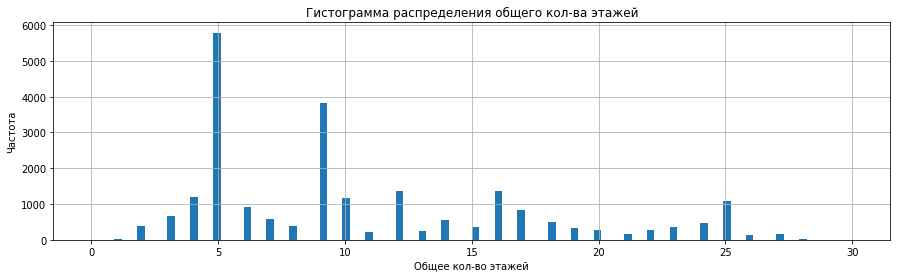

In [ ]:
data['floors_total'].hist(bins=100, range=(0,30), figsize=(15, 4))
plt.xlabel('Общее кол-во этажей')
plt.ylabel('Частота')
plt.title('Гистограмма распределения общего кол-ва этажей')
abnormal_floors_total = data.loc[(data['floors_total'] < 2) | (data['floors_total'] > 27)].index
data.drop(index=abnormal_floors_total, axis=0, inplace=True)

In [ ]:
loss_ration_floors_total = ((len(abnormal_floors_total) / length) * 100)
round(loss_ration_floors_total, 2)

0.33

Процент отбрасываемых в данном столбце значений равен 0.33% и меньше 1 %, что можно считать приемлемым результатом.

Подозрительные значения были обнаружены в столбце высоты потолков. Там присутствовали значения, больше 20 м. Так как минимально установленная высота потолка в России - 2.5 м, то все значения выше можно считать ошибочно введенными и разделить их на 10. Чтобы убедиться в справедливости этого можно посмотреть на населенные пункты и параметры квартир, в которых встречаются такие потолки и убедиться, что для поселков и деревень в 1- и 2-х комнатных квартирах это маловероятно.

После замены  посмотрим на оставшиеся значения, большие 4. Одновременно с этим рассмотрим строки с аномально малыми значениями, т.е. меньшими 2.4. Отступ от нормы в 2.5 м был сделан по причине возможного поднятия полов жильцами или использования навесных потолков. Удалим отфильтрованные строки.

In [ ]:
#Обработка выбросов в столбце высоты потолков
length = len(data['ceiling_height'])
data.loc[data['ceiling_height'] > 24, 'ceiling_height'] /= 10
abnormal_ceiling_height = data.loc[(data['ceiling_height'] < 2.4) | (data['ceiling_height'] > 4)].index
data.drop(index=abnormal_ceiling_height, axis=0, inplace=True)
loss_ration_ceiling_height = ((len(abnormal_ceiling_height) / length) * 100)
round(loss_ration_ceiling_height, 2)

0.32

Доля удаленных строк по данному столбцу меньше 1%, следовательно наши действия не внисут серьезных искажений в данные.

Рассмотрим значения в столбце с площадью кухни. В однокомнатных квартирах допускается проектировать кухни или кухни-ниши площадью не менее 5 м², согласно нормативным документам, поэтому посмотрим количество данных с меньшими площадями. Допустим, из-за особенностей планировки площадь кухни могла быть урезана на 0.1-1 м², тогда отбросим отбросим несоответствующие данные.

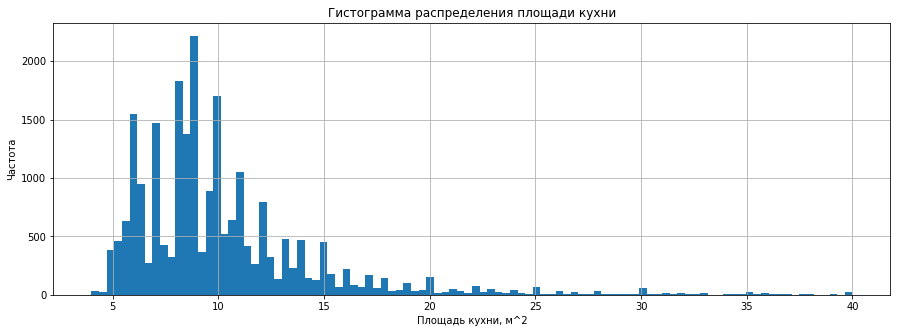

In [ ]:
#Обработка значений в столбце площади кухни
length = len(data['kitchen_area'])
data['kitchen_area'].hist(bins=100, range=(4, 40), figsize=(15, 5))
plt.xlabel('Площадь кухни, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма распределения площади кухни')
abnormal_kitchen_area = data.loc[(data['kitchen_area'] < 4) | (data['kitchen_area'] > 40)].index
data.drop(index=abnormal_kitchen_area, axis=0, inplace=True)

In [ ]:
loss_ration_kitchen_area = ((len(abnormal_kitchen_area) / length) * 100)
round(loss_ration_kitchen_area, 2)

0.65

Доля удаленных строк равно 0.65% < 1%, следовательно результат приемлимый.

Проанализируем значения жилой площади. Согласно нормам она должна составлять не менее 14 м², однако существую квартиры и с меньшей площадью. Очевидно то, что такая квартира не может иметь больше 1 комнаты. Проверим наличие иных данных в датафрейме и предположим, что значения в 'living_area' соответствуют площади одной из комнат. Тогда такие данные можно исправить, умножив данный столбец для выбранных данных на количество комнат.

Затем построим гистограмму распределения жилых площадей и определим по ней значения, которые предположительно можно отбросить (нижнюю границу возьмем по нормам СНиП - 7 м², а верхнюю по гистрограмме - 125 м²), отбросим их и проверим долю отброшенных значений, чтобы подтвердить верность действий.

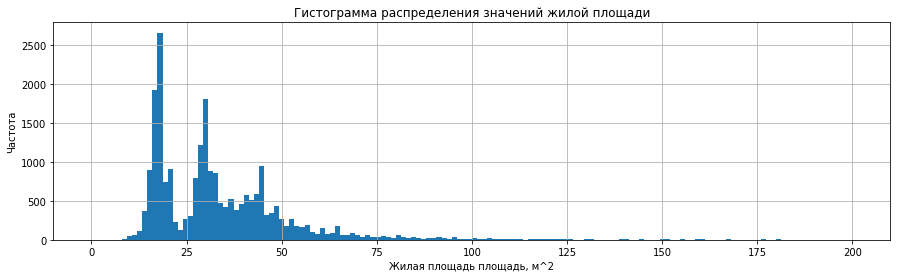

In [ ]:
#Обработка значений в столбце жилой площади
length = len(data['living_area'])
data.loc[(data['living_area'] < 14) & (data['rooms'] > 1), 'living_area'] *= (
    data.loc[(data['living_area'] < 14) & (data['rooms'] > 1), 'rooms']
)

data['living_area'].hist(bins=150, range=(0, 200), figsize=(15, 4))
plt.xlabel('Жилая площадь площадь, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений жилой площади')
abnormal_living_area = data.loc[(data['living_area'] < 7) | (data['living_area'] > 125)].index
data.drop(index=abnormal_living_area, axis=0, inplace=True)

In [ ]:
loss_ration_living_area = ((len(abnormal_living_area) / length) * 100)
round(loss_ration_living_area, 2)

0.75

В результате получили долю вы брошенных значений - 0.75% < 1%.

При анализе данных было обнаружено, что для некоторых данных суммарная площадь квартиры меньше жилой площади и кухни. Так как такое невозможно исправим значение суммарной площади квартиры на сумму жилой площади и 1.5 площади кухник. Домножение на коэффициент предполагет учет наличия коридора, санузла и т.д.

In [ ]:
#Обработка значений в столбце суммарной площади
length = len(data['total_area'])
len(data.loc[(data['living_area'] + data['kitchen_area']) >= 0.9 * data['total_area']])

879

In [ ]:
data.loc[(data['living_area'] + data['kitchen_area']) > data['total_area'], 'total_area'] = (
    1.5 * data.loc[data['living_area'] > data['total_area'], 'kitchen_area']
    + data.loc[data['living_area'] > data['total_area'], 'living_area']
)

Теперь, после обработки данных отбросим выделяющиеся данные по гистограмме. Согласно нормам квартира должна быть не менее 28 м², однако в зависимости от юридического статуса помещения площадь может быть и меньше. Согласно второй гистограмме поставим нижнюю границу равную 15 м², а верхнюю 200 м². Проверим долю теряемых значений.

Text(0.5, 1.0, 'Гистограмма распределения значений суммарной площади')

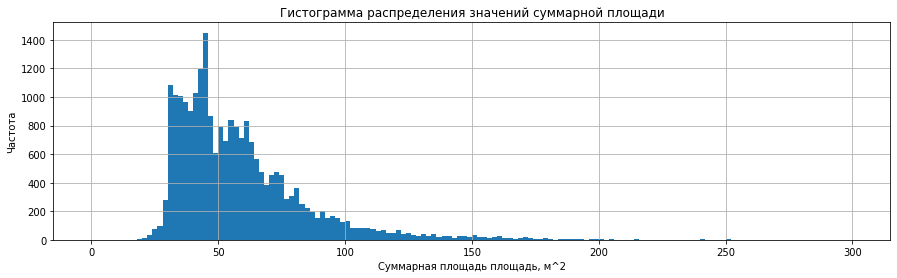

In [ ]:
data['total_area'].hist(bins=150, range=(0, 300), figsize=(15, 4))
plt.xlabel('Суммарная площадь площадь, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений суммарной площади')

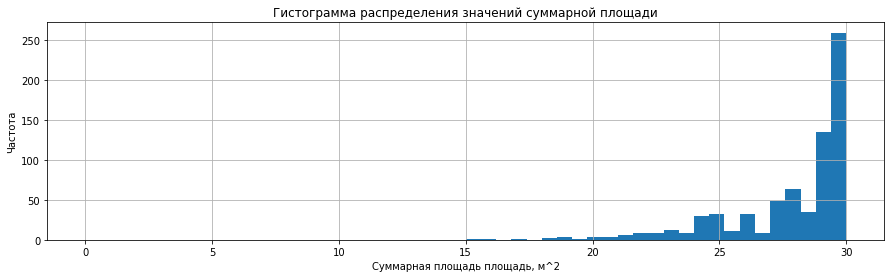

In [ ]:
data['total_area'].hist(bins=50, range=(0, 30), figsize=(15, 4))
plt.xlabel('Суммарная площадь площадь, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений суммарной площади')
abnormal_total_area = data.loc[(data['total_area'] < 15) | (data['total_area'] > 200)].index
data.drop(index=abnormal_total_area, axis=0, inplace=True)

In [ ]:
loss_ration_total_area = ((len(abnormal_total_area) / length) * 100)
round(loss_ration_total_area, 2)

0.2

Полученный коэффициент равен 0.2% < 1%.

Проанализируем значения в столбце количества комнат. Для некоторых квратир приведено значение 0. Данный показатель возможен только для квартир студий. Посмотрим количество квартир, не удовлетворяющих данному условию и удалим их.

Также построим гистограмму и по ней определим граничные значения для удаления выбросов.

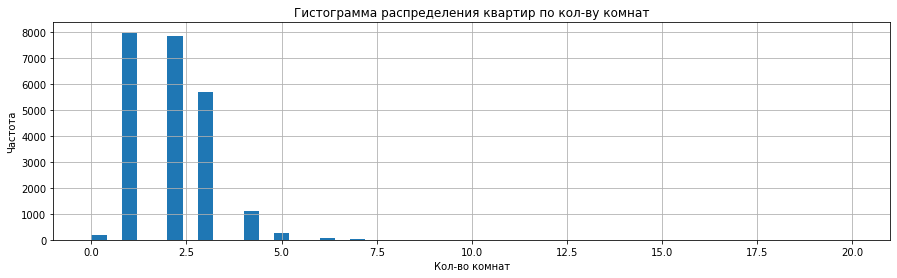

In [ ]:
#Обработка значений в столбце комнат
length = len(data['rooms'])
abnormal_rooms = data.loc[(data['rooms'] == 0) & (data['studio'] == False)].index
data['rooms'].hist(bins=50, range=(0, 20), figsize=(15, 4))
plt.xlabel('Кол-во комнат')
plt.ylabel('Частота')
plt.title('Гистограмма распределения квартир по кол-ву комнат')
abnormal_rooms = (data.loc[(data['rooms'] > 7)].index)
data.drop(index=abnormal_rooms, axis=0, inplace=True)

In [ ]:
loss_ration_rooms = ((len(abnormal_rooms) / length) * 100)
round(loss_ration_rooms, 2)

0.01

Полученный коэффициент меньше единицы, поэтому подобная фильтрация данных правомерна.

Теперь рассмотрим значения количества дней, которые было выставлено объявление. В среднем срочный выкуп квартиры длится от 3 до 14 дней, следовательно в качестве нижней границы возьмем значение в 3 дня.

Теперь посмотрим на верхнюю границу. Обратим внимание, что в данном столбце много пропущенных значений, поэтому отбрасывать данные надо осторожно. По описательной статистике, приведенной в начале анализа столбцов видим, что существуют объявления, которые были размещены до 4 с лишним лет. Можно предположить, что хозяин забыл удалить объявление, а сама квартира не пользовалась большим спросом. Такие значения могут испортить результаты измерений и должны являться редкими. По гистограмме видно, что количество объявлений, провисевших больше примерно 1100 дней мало. Попробуем принять 1100 за верхнюю границу и отфильтровать данные.

20107

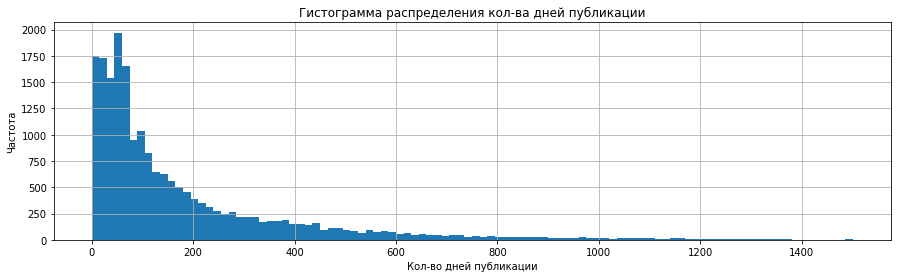

In [ ]:
#Обработка значений в столбце дней размещения объявлений
length = len(data['days_exposition'])
data['days_exposition'].hist(bins=100, range=(0, 1500), figsize=(15, 4))
plt.xlabel('Кол-во дней публикации')
plt.ylabel('Частота')
plt.title('Гистограмма распределения кол-ва дней публикации')
data['days_exposition'].count()

In [ ]:
abnormal_days_exposition = data.loc[(data['days_exposition'] < 3) | (data['days_exposition'] > 1100)].index
data.drop(index=abnormal_days_exposition, axis=0, inplace=True)
loss_days_exposition = ((len(abnormal_days_exposition) / length) * 100)
round(loss_days_exposition, 2)

0.68

Коэффициент меньше 1, следовательно потери премлемы.

Рассмотрим значения в столбце last_price и оценим какие из них пригодны для анализа. Согласно описанию данных есть квартиры, которые стоят меньше 100000 у.е. На фоне общих данных это выглядит подозрительным. Посмотрим сколько таких значений и, обнаружив, что подобных данных в выборке не осталось, сделаем вывод, что они были удалены в ходе предвествующих обработок, что подтверждает, что фильтрация происходит правильно.

По гистограмме видно, для величин, больших 30 млн у.е. данных встречается гораздо меньше, чем для величин меньших этой границы. Попробуем отфильтровать данные по данному значению и посмотрим на коэффициент потерь.

Text(0.5, 1.0, 'Гистограмма распределения значений стоимости квартиры')

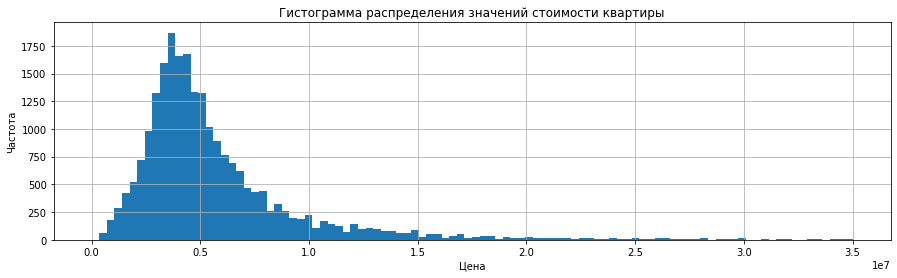

In [ ]:
#Обработка значений в столбце итоговой стоимости
length = len(data['last_price'])
data['last_price'].hist(bins=100, range=(0, 35000000), figsize=(15, 4))
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений стоимости квартиры')

In [ ]:
len(data.loc[data['last_price'] < 1e+5])

0

In [ ]:
abnormal_last_price = data.loc[data['last_price'] > 3e+7].index
data.drop(index=abnormal_last_price, axis=0, inplace=True)
loss_last_price = ((len(abnormal_last_price) / length) * 100)
round(loss_last_price, 2)

0.65

Доля удаленных данных меньше 1, значит результат приемлемый.

В описании данных видно, что существуют строки, для которых расстояние до аэропорта равно 0. Очевидно, что такое невозможно, поэтому удалим эти значения.

In [ ]:
#Обработка значений в столбце ближайших аэропортов
length = len(data['airports_nearest'])
abnormal_airports_nearest = data.loc[data['airports_nearest'] == 0].index
data.drop(abnormal_airports_nearest, inplace=True)
loos_airports_nearest = ((len(abnormal_airports_nearest) / length) * 100)
round(loos_airports_nearest, 2)

0.0

#### Итог обработки

Выведем описательную статистику для нового датафрейма и проверим общую долю удаленных строк.

In [ ]:
#Выведем описательную статистику для получившегося датафрейма
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,22860.000000,2.286000e+04,22596.000000,22860.000000,22860.000000,22860.000000,22860.000000,22860.000000,22669.000000,22860.000000,17403.000000,17423.000000,22860.000000,7625.000000,22860.000000,8583.000000,19839.000000
mean,9.819948,5.610159e+06,57.315470,2.014829,2.686462,10.716492,32.587601,5.892738,10.041810,0.594313,28850.699017,14410.360558,0.451662,493.168262,0.567017,525.580450,170.734866
std,5.643626,3.800760e+06,24.572666,0.974408,0.192942,6.525347,16.193560,4.862594,4.330857,0.958605,12750.803694,8560.814181,0.729401,340.011836,0.861622,277.040784,196.826851
min,0.000000,4.300000e+05,15.500000,0.000000,2.400000,2.000000,8.000000,1.000000,4.000000,0.000000,6450.000000,208.000000,0.000000,1.000000,0.000000,13.000000,3.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.200000,2.000000,7.200000,0.000000,18420.000000,9700.000000,0.000000,290.000000,0.000000,305.000000,44.000000
50%,9.000000,4.580000e+06,51.400000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26895.000000,13230.000000,0.000000,456.000000,0.000000,510.000000,93.000000
75%,14.000000,6.500000e+06,68.000000,3.000000,2.700000,16.000000,42.000000,8.000000,11.200000,1.000000,37412.000000,16383.000000,1.000000,614.000000,1.000000,734.000000,222.000000
max,50.000000,3.000000e+07,200.000000,7.000000,4.000000,27.000000,125.000000,27.000000,40.000000,5.000000,84853.000000,65952.000000,3.000000,3190.000000,3.000000,1344.000000,1100.000000


In [ ]:
round((1 - len(data) / total_length) * 100, 2)

3.54

Вывод: Пропуски в столбцах 'is_apartment' и 'balcony' пропуски были заполнены 0. Пропуски в столбце 'ceiling_height' и 'total_floors' заполны медианным значением по всем данным, так как первая величина в большинстве случаев задается параметрами С СНиПов в небольшом диапазоне, а вторая величина в нашем случае будет отображать среднюю высоту домов по городу. Была проведена проверка, чтобы этаж квартиры не был больше общей высоты, несоответствия были обработаны так, чтобы общая высота равнялась высоте этажа. Для заполнения пропусков в столбцах 'living_area' и 'kitchen_area' были написаны функции, учитывающие подобные квартиры. Данные, для которых не указан населенный пункт были объеденины в категорию 'Другое'.

В данном пункте были также устранены неявные дуюликаты в названиях населенных пунктов.

При поиске выбивающихся значений для основных столбцов данных были построены гистограммы и проанализированы статистические данные, по которым  были отброшены аномально большие и малые значения. При этом учитывалось, что объем отбрасываемых данных не должен превышать 1% от всех имеющихся в данном столбце значений. Для типовых параметров были найдены нормы и данные были отфильтрованы и изменены в соответствии с ними. Некоторые строки были удалены, так как невозможно установить зависимости для исправления неверных данных в них.

В результате всех замен и фильтрации значений мы посчитали общий коэффициент потерь по всем столбцам и получили значение равное 3.52%, что является хорошим показателем.

### Посчитаем и добавим в таблицу новые столбцы

In [ ]:
#возращает тип этажа
def floor_type(line):
    if line['floor'] == 1:
        return 'Первый'
    elif line['floor'] == line['floors_total']:
        return 'Последний'
    elif line['floor'] == 0:
        return 'Нулевой'
    elif line['floor'] < 0:
        return 'Другой (подземный)'
    else:
        return 'Другой'

data['floor'].describe()

count    22860.000000
mean         5.892738
std          4.862594
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

In [ ]:
#добавление столбцов с новыми данными
data['sq_m_price'] = data['last_price'] / data['total_area']
data['week_day'] = data['first_day_exposition'].dt.dayofweek
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year
data['floor_type'] = data.apply(floor_type, axis=1)
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round()

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality,sq_m_price,week_day,exposition_month,exposition_year,floor_type,city_centers_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,120370.370370,3,3,2019,Другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,82920.792079,1,12,2018,Первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,92785.714286,3,8,2015,Другой,14.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,Янино-1,95065.789474,0,9,2018,Другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,Парголово,99195.710456,3,11,2017,Другой,19.0


Вывод: Для анализа данных были добавлены новые столбцы согласно заданию. Для определения типа этажа была написана функция, возвращающая одно из следующих значений: первый, последний, другой, другой(подземный) и нулевой. В рамках нашего датафрейма последние 2 типа появиться не могут, так как значение этажа - целое положительно число, но теоретически подобные значения возможны.

### Проведите исследовательский анализ данных

#### Исследование отдельных параметров

,total_area
count,22596.000000
mean,57.315470
std,24.572666
min,15.500000
25%,40.000000
50%,51.400000
75%,68.000000
max,200.000000


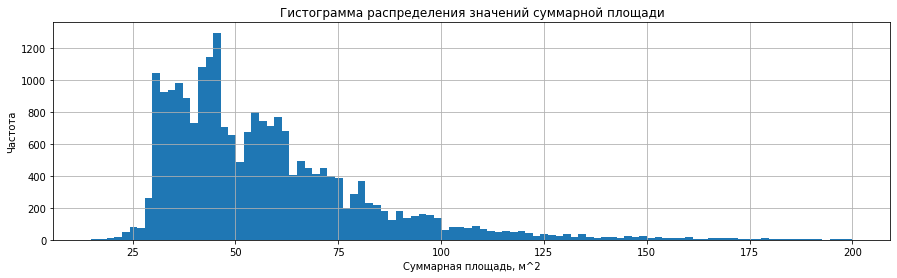

In [ ]:
#Total_area
data['total_area'].plot( kind='hist', bins=100, range=(15, 200), figsize=(15, 4), grid=True)
plt.xlabel('Суммарная площадь, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений суммарной площади')
data['total_area'].describe().to_frame()

На гистограмме наблюдаем максимум в области 40 квадратных меров, что примерно соответствует первому квартилю. Также с ростом площади наблюдается тенденция к уменьшению количества квартир, так как за счет этого повышается стоимость квартиры и меньшее количество людей может позволить себе купить ее, а следовательно и уменьшается спрос на подобные квартиры. Для удобства анализа диаграммы ее диапазон был уменьшен, но по таблице видим, что также существуют значения, превышающие площадь в 200 квадратных метров.

,living_area
count,22860.000000
mean,32.587601
std,16.193560
min,8.000000
25%,18.200000
50%,30.000000
75%,42.000000
max,125.000000


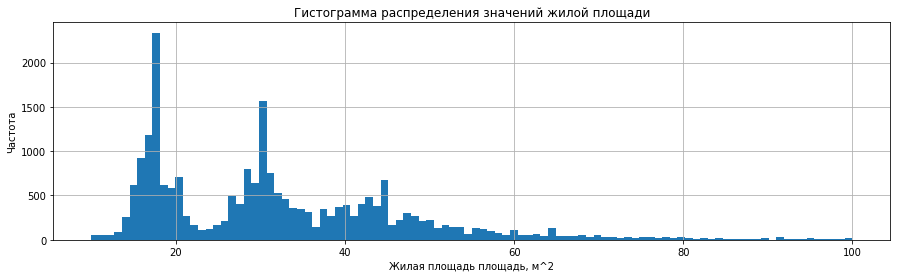

In [ ]:
#Living_area
data['living_area'].hist(bins=100, range=(10, 100), figsize=(15, 4))
plt.xlabel('Жилая площадь площадь, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений жилой площади')
data['living_area'].describe().to_frame()

На гистограмме наблюдаем 3 выраженных локальных макисмума, примерно соответствующих квартилям 1, 2 и 3, причем большей части данных соответствует плащдь от 18.5 до 42.8, хотя присутствуют и значения, выходящие за данный диапазон. Аналогично прошлому пункту по таблице видим, что также существуют значения, превышающие площадь в 100 квадратных метров.

,kitchen_area
count,22669.000000
mean,10.041810
std,4.330857
min,4.000000
25%,7.200000
50%,9.000000
75%,11.200000
max,40.000000


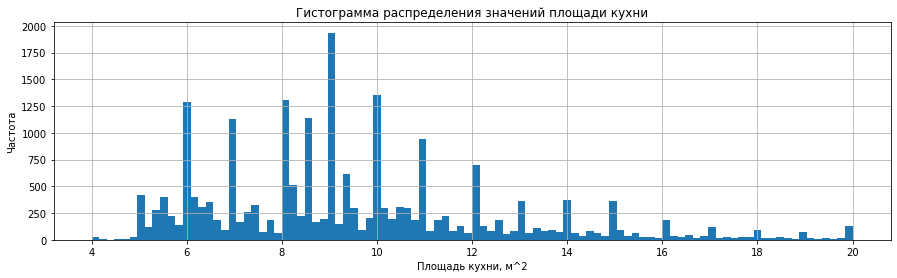

In [ ]:
#Kitchen_area
data['kitchen_area'].hist(bins=100, range=(4, 20), figsize=(15, 4))
plt.xlabel('Площадь кухни, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений площади кухни')
data['kitchen_area'].describe().to_frame()

По данной гистограмме можно сказать, что большая часть кухонь имеет типичные целые размеры, такие как \[6, 7, 8, 9 ...\]. Причем самой популярной площадью является 9 метров квадратных, что соответствует медианному значению.

,last_price
count,22860.000000
mean,5.610159
std,3.800760
min,0.430000
25%,3.400000
50%,4.580000
75%,6.500000
max,30.000000


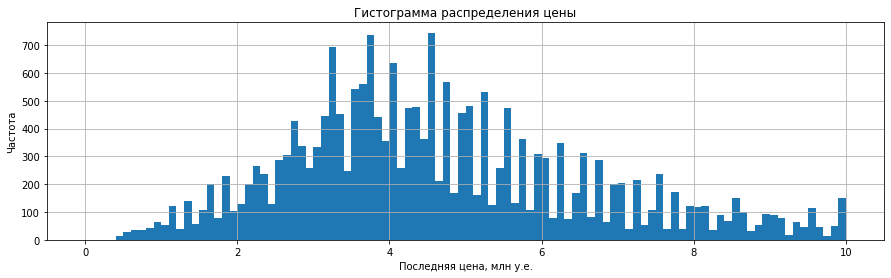

In [ ]:
#Last_price
(data['last_price'] / 1e+6).hist(bins=100, range=(0, 10), figsize=(15, 4))
plt.xlabel('Последняя цена, млн у.е.')
plt.ylabel('Частота')
plt.title('Гистограмма распределения цены')
(data['last_price'] / 1e+6).describe().to_frame()

Для удобства анализа и отображения преобразуем цену из условных единиц (так как в описании к датафрейму не была указана валюта) в миллионы у.е. По внешнему виду распределение очень приближенно можно считать нормальным. Медианное значение равно 4.65 млн у.е., что попадает в область максимума на графике, однако из-за большой ширины этой области можно говорить о большой веричине среднего отклонения, что подтверждает величина std=10.9. Основная часть значений состредоточена в диапазоне от 3.45 до 6.8, но есть выбивающиеся за эти границы значения, в том числе большие 10 млн у.е.

,rooms
count,22860.000000
mean,2.014829
std,0.974408
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,7.000000


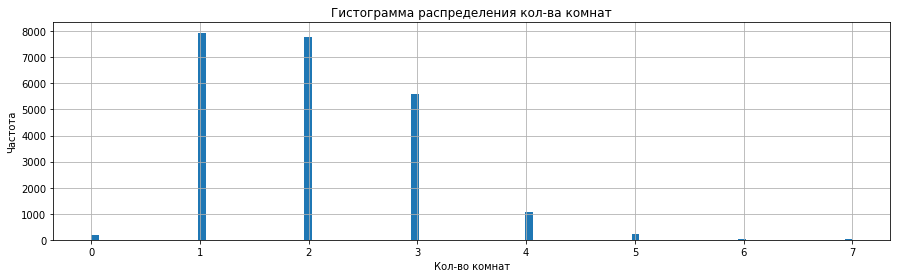

In [ ]:
#Rooms
data['rooms'].hist(bins=100, range=(0, 7), figsize=(15, 4))
plt.xlabel('Кол-во комнат')
plt.ylabel('Частота')
plt.title('Гистограмма распределения кол-ва комнат')
data['rooms'].describe().to_frame()

По данной гистограмме можно сказать, что величина имеет целочисленный тип данных, а также больше всего квартир с 1 и 2 комнатами (их примерно одинаковое количество), реже встречаютсчя квартиры с 4, затем 5, 6 комнатами. Также встречаются квартиры студии. По таблице также можно сказать, что встречаются и квартиры с количесьтвом квартир большем 10.

,ceiling_height
count,22860.000000
mean,2.686462
std,0.192942
min,2.400000
25%,2.600000
50%,2.650000
75%,2.700000
max,4.000000


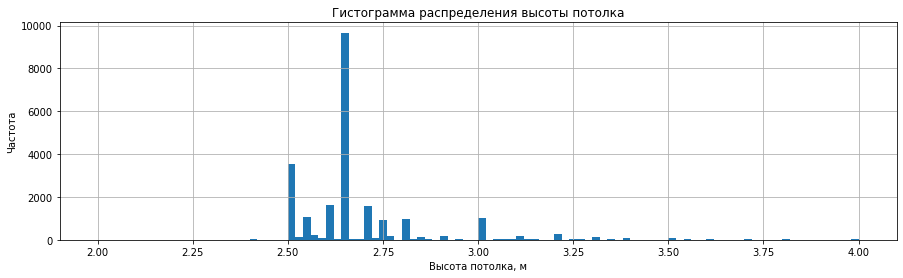

In [ ]:
#Ceiling_height
data['ceiling_height'].hist(bins=100, range=(2, 4), figsize=(15, 4))
plt.xlabel('Высота потолка, м')
plt.ylabel('Частота')
plt.title('Гистограмма распределения высоты потолка')
data['ceiling_height'].describe().to_frame()

По данной гистограмме видно, что наиболеечасто встречающиеся значение высоты потолков примерно равно 2.6 (2.65 по таблице). Также из таблицы видно, что существуют квартиры с потолками выше 4 м.

,floor
count,22860.000000
mean,5.892738
std,4.862594
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,27.000000


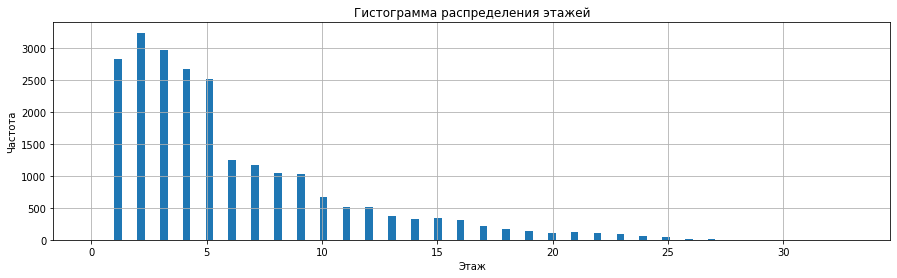

In [ ]:
#Floor
data['floor'].hist(bins=100, range=(0, 33), figsize=(15, 4))
plt.xlabel('Этаж')
plt.ylabel('Частота')
plt.title('Гистограмма распределения этажей')
data['floor'].describe().to_frame()

По гистограмме видно, что данные имеют целочисленный тип данных. Гистограммы в некотором приближеннии имеет ступенчатый вид. Наиболле часто встречаются квартиры до 5 этажа. Медианное значение по таблице - 4 этаж.

Text(0.5, 1.0, 'Гистограмма распределения по типам этажей')

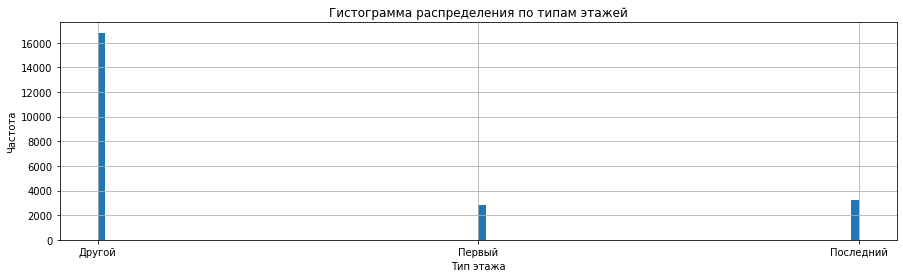

In [ ]:
#Floor_type
data['floor_type'].hist(bins=100, range=(0, 2), figsize=(15, 4))
plt.xlabel('Тип этажа')
plt.ylabel('Частота')
plt.title('Гистограмма распределения по типам этажей')

Из этой диаграммы видно, что данный столбец принимает 3 значения строкового типа, тип этажа для большей части квартир соответствует другому, т.е. не является ни первым, ни последним. Количество квартир на последнем этаже несколько больше, чем количество квартир на первом, однако данные по количеству квартир могут не соответстсвовать действительности из-за особенностей заполнения пропусков, поэтому опираться при анализе на этот столбец нежелательно.

,floors_total
count,22860.000000
mean,10.716492
std,6.525347
min,2.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,27.000000


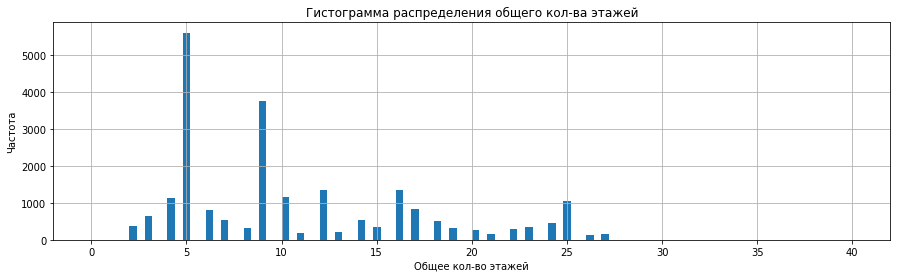

In [ ]:
#Floors_total
data['floors_total'].hist(bins=100, range=(0, 40), figsize=(15, 4))
plt.xlabel('Общее кол-во этажей')
plt.ylabel('Частота')
plt.title('Гистограмма распределения общего кол-ва этажей')
data['floors_total'].describe().to_frame()

По данной гистограмме можно сделать вывод о наиболее часто встречающейся высоте зданий. Так, больше всего в представленном датафрейме находится 5 этажных зданий. Также пприсутствует немало 9 этажных зданий. Значения в данном столбце представленны целочисленным типом.

,city_centers_nearest_km
count,17423.000000
mean,14.404236
std,8.568764
min,0.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,66.000000


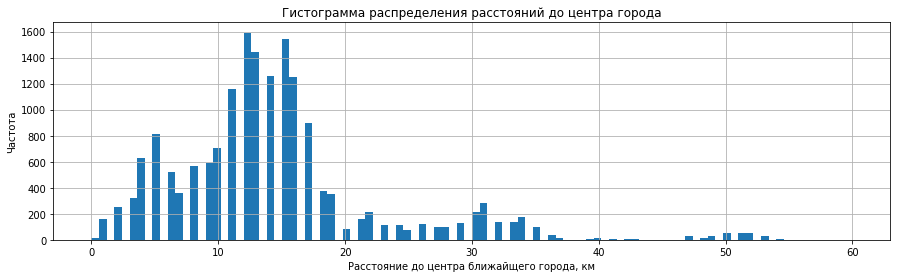

In [ ]:
#City_centers_nearest_km
data['city_centers_nearest_km'].hist(bins=100, range=(0, 60), figsize=(15, 4))
plt.xlabel('Расстояние до центра ближайщего города, км')
plt.ylabel('Частота')
plt.title('Гистограмма распределения расстояний до центра города')
data['city_centers_nearest_km'].describe().to_frame()

На данной гистограмме для анализа данных можно выделить 3 максимума. Первый находится на расстоянии около 5 км, второй - 13-18 км, третий - 30 км. Также мы видим небольшое скопление квартир, находящихся на расстонии 50-55 км от центра города.

,airports_nearest
count,17403.000000
mean,28.850699
std,12.750804
min,6.450000
25%,18.420000
50%,26.895000
75%,37.412000
max,84.853000


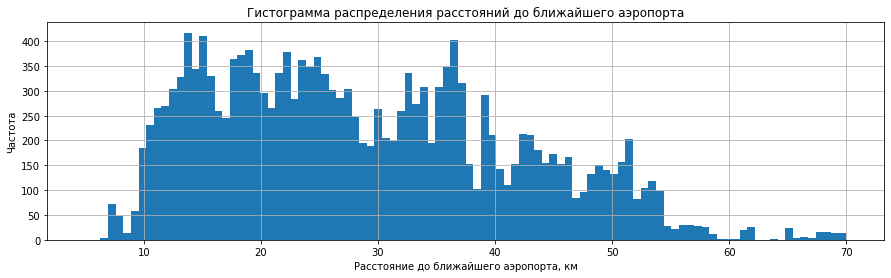

In [ ]:
#Airports_nearest
(data['airports_nearest'] / 1000).hist(bins=100, range=(5, 70), figsize=(15, 4))
plt.xlabel('Расстояние до ближайшего аэропорта, км')
plt.ylabel('Частота')
plt.title('Гистограмма распределения расстояний до ближайшего аэропорта')
(data['airports_nearest'] / 1000).describe().to_frame()

Для удобства переведем данные в км. По построенной гистограмме и выведенной таблице можно сказать, что основная часть квартир продается на расстоянии от 10 до 40 км.

,parks_nearest
count,7625.000000
mean,493.168262
std,340.011836
min,1.000000
25%,290.000000
50%,456.000000
75%,614.000000
max,3190.000000


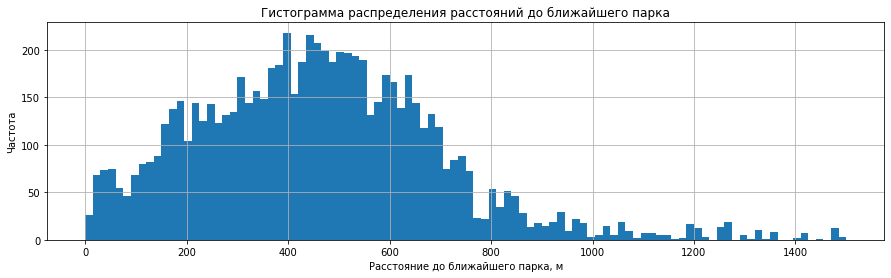

In [ ]:
#Parks_nearest
data['parks_nearest'] .hist(bins=100, range=(0, 1500), figsize=(15, 4))
plt.xlabel('Расстояние до ближайшего парка, м')
plt.ylabel('Частота')
plt.title('Гистограмма распределения расстояний до ближайшего парка')
data['parks_nearest'] .describe().to_frame()

Распределение значений на построенной диаграмме в некотором приближении можно считать нормальным. Основная часть квартир, для которых параметр прописан, находятся на расстонии  300 - 600 м от парка. По таблице видно, что присутствуют значения, большие 1500 м.

Text(0.5, 1.0, 'Гистограмма распределения публикаций по месяцам')

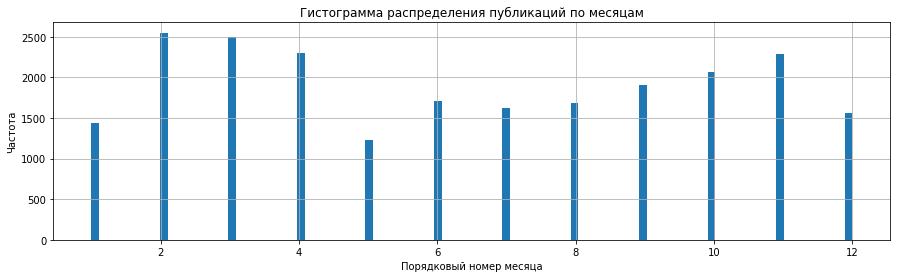

In [ ]:
#Month
data['exposition_month'] .hist(bins=100, range=(1, 12), figsize=(15, 4))
plt.xlabel('Порядковый номер месяца')
plt.ylabel('Частота')
plt.title('Гистограмма распределения публикаций по месяцам')

Text(0.5, 1.0, 'Гистограмма распределения публикаций по дням')

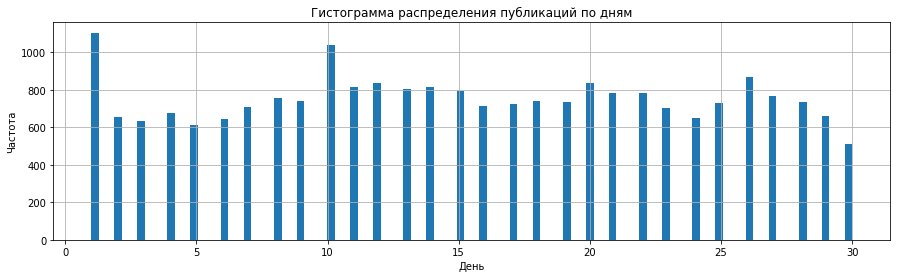

In [ ]:
#Day
data['first_day_exposition'].dt.day.hist(bins=100, range=(1, 30), figsize=(15, 4))
plt.xlabel('День')
plt.ylabel('Частота')
plt.title('Гистограмма распределения публикаций по дням')

Text(0.5, 1.0, 'Гистограмма распределения публикаций по дням недели')

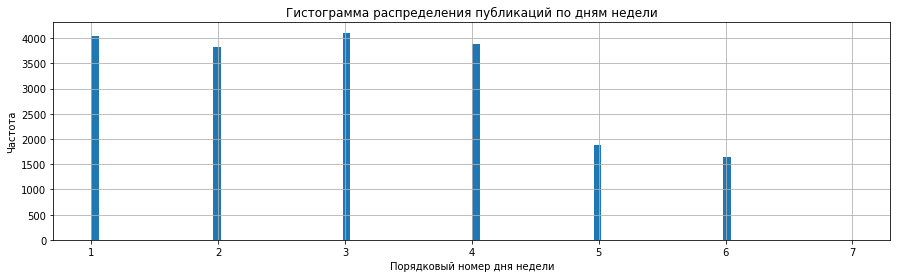

In [ ]:
#Weekday
data['first_day_exposition'].dt.weekday.hist(bins=100, range=(1, 7), figsize=(15, 4))
plt.xlabel('Порядковый номер дня недели')
plt.ylabel('Частота')
plt.title('Гистограмма распределения публикаций по дням недели')

По гистограммам видно, что большая часть заявлений о продаже квартир публикуется в феврале-апреле, ноябре, причем для публикации чаще всего выбираются 1 и 10 число.

Если смотреть на гистограмму дней недели, то заметим, что в основном объявления публикуются с понедельника по четверг. Это можно объяснить тем, что нередко составление и публикацию объявлений поручают риелторам, которые не работают по выходным. При этом можно заметить, что ни одно объявление не было выставлено в воскресенье. Это может быть связано с тем, что перед публикацией объявления его неоходимо проверить вручную, а сотрудники ресурса с объявляениями не работают в воскресенье. Этим также можно объяснить спад публикаций в пятницу/воскресенье.

#### Оценка скорости продаж

,days_exposition
count,19839.000000
mean,170.734866
std,196.826851
min,3.000000
25%,44.000000
50%,93.000000
75%,222.000000
max,1100.000000


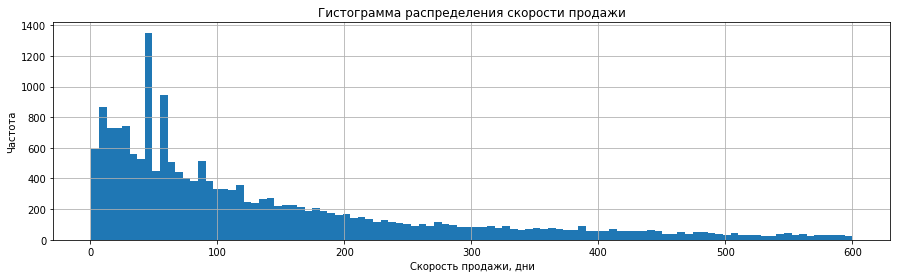

In [ ]:
#Скорость продажи
data['days_exposition'].hist(bins=100, range=(1,600), figsize=(15, 4))
plt.xlabel('Скорость продажи, дни')
plt.ylabel('Частота')
plt.title('Гистограмма распределения скорости продажи')
data['days_exposition'].describe().to_frame()

Text(0.5, 1.0, 'Изменение средней скорости продажи с 2014 по 2019 года')

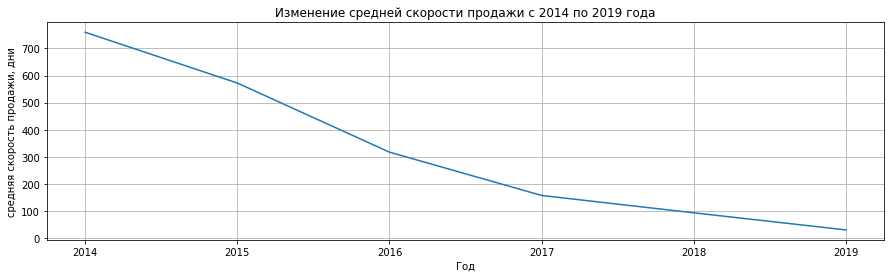

In [ ]:
data.groupby('exposition_year')['days_exposition'].mean().plot(grid=True, figsize=(15, 4))
plt.xlabel('Год')
plt.ylabel('средняя скорость продажи, дни')
plt.title('Изменение средней скорости продажи с 2014 по 2019 года')

Из описания данных можно сделать вывод, что в среднем на продажу квартиры тратиться от 45 до 232 дней и это считается нормальным временем. Длительность, не попадающая в эти рамки может считаться аномальной. Это может быть связано с разными причинами. Долгое время продажи можно объяснить например плохо составленных объявлением или плохими условиями и особенностями самой квартиры. Быстрая продажа может быть объяснена грамотным объявлением, своевременной публикацией, хорошей обратной связью по заявлению, выгодными условиями.

Наиболее часто встречающееся значение скорости продажи примерно равно 50 дням. Такое значение можно объяснить тем, что в наших данных предствалены квартиры, стоимость 50% из которых попадает в категорию до 4,5 млн у.е. Согласно информации с рессурса по продажам квартир среднее время продажи недвижимости в таком ценовом диапазоне - 45 дней, что согласовывается с нашими результатами.

#### Исследование факторов, влияющих на стоимость квартиры

Проанализируем зависимость цены от общей площади. Для этого составим сводную таблицу, а предварительно категоризируем данные по общей площади.

In [ ]:
#Возращает сводную таблицу и печатает разделение данных на категории
def dep(param, num=10):
    step = (max(data[param]) - min(data[param])) / num
    cat = []
    for i in range(num + 1):
        cat.append(str(int(step * i)) + ' - ' + str(int(step * (i + 1))))
    print(pd.DataFrame({'categories':cat}))

    def cat(line):
        for i in range(num + 1):
            if line[param] <= step * (i + 1):
                return i

    data[param + '_cat'] = data.apply(cat, axis=1)
    return data.pivot_table(index=param+'_cat', values='last_price', aggfunc='median')

In [ ]:
#Last_price(total_area)
total_stat = dep('total_area', 15)
total_stat

   categories
0      0 - 12
1     12 - 24
2     24 - 36
3     36 - 49
4     49 - 61
5     61 - 73
6     73 - 86
7     86 - 98
8    98 - 110
9   110 - 123
10  123 - 135
11  135 - 147
12  147 - 159
13  159 - 172
14  172 - 184
15  184 - 196


,last_price
total_area_cat,
1.0,2400000.0
2.0,3190000.0
3.0,3975000.0
4.0,4950000.0
5.0,6150000.0
6.0,7400000.0
7.0,9300000.0
8.0,11900000.0
9.0,12700000.0


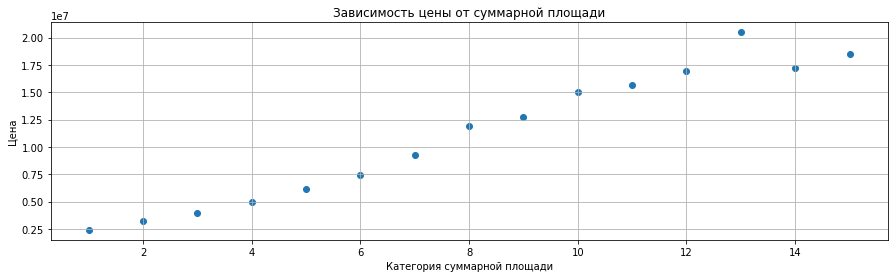

In [ ]:
plt.figure(figsize=(15, 4))
plt.xlabel('Категория суммарной площади')
plt.ylabel('Цена')
plt.title('Зависимость цены от суммарной площади')
plt.scatter(x=total_stat.index, y=total_stat['last_price'])
plt.grid(True)

In [ ]:
round(data['total_area'].corr(data['last_price']), 2)

0.78

Как видно из графика с ростом общей площади наблюдается рост цены, однако для квартир площадью от 172 до 184 квадратных метров, наблюдается непольшой провал в цене по сравнению с квартирами с площадью от 184 до 196 квадратных метров. Это можно объяснить другими параметрами квартир, представленных в датафрейме.

По характеру возрастания графика можно сказать, что на участке от 0 категории до 12 включительно цена за квартиру возрастает с ростом площади по линейной зависимости.

Совпадение с линейной зависимостью подтверждает также довольно высокий коэффициент корреляции.

In [ ]:
#Last_price(kitchen_area)
kitchen_stat = dep('kitchen_area', 15)
kitchen_stat

   categories
0       0 - 2
1       2 - 4
2       4 - 7
3       7 - 9
4      9 - 12
5     12 - 14
6     14 - 16
7     16 - 19
8     19 - 21
9     21 - 24
10    24 - 26
11    26 - 28
12    28 - 31
13    31 - 33
14    33 - 36
15    36 - 38


,last_price
kitchen_area_cat,
1.0,2780000.0
2.0,3620000.0
3.0,4200000.0
4.0,5100000.0
5.0,6550000.0
6.0,7900000.0
7.0,9675000.0
8.0,9811452.0
9.0,10800000.0


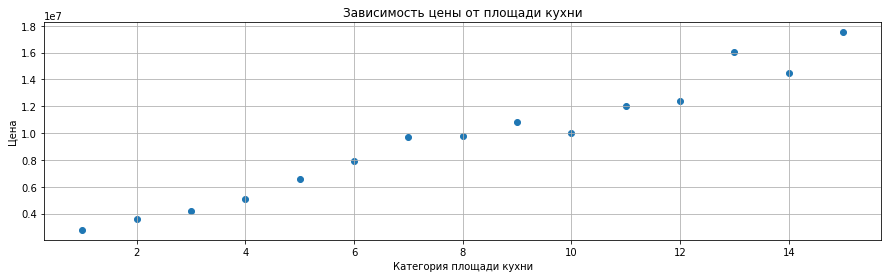

In [ ]:
plt.figure(figsize=(15, 4))
plt.xlabel('Категория площади кухни')
plt.ylabel('Цена')
plt.title('Зависимость цены от площади кухни')
plt.scatter(x=kitchen_stat.index, y=kitchen_stat['last_price'])
plt.grid(True)

In [ ]:
round(data['kitchen_area'].corr(data['last_price']), 2)

0.57

По графику видно, что с ростом размера кухни растет и стоимость квартиры, но не так сильно, как с ростом общей площади квартиры. Аналогично зависимости от общей площади можно отметить небольшой провал для высоких значений площадей, в данном случае между категориями 13 и 15.

В отличие от преидущего примера здесь уже нельзя говорить о линейной зависимости на всем диапазоне категорий до 12 включительно из-за в какой-то мере постоянного значения цены на жилье при переходе от категории 7 к 10. Все это, как и в прошлом пункте, может объясняться тем, что с улучшением одного параметра могут ухудшаться другие, а итоговая стоимость зависит от всех параметров квартиры.

Пониженный коэффициент корреляции по сравнению с предидущим графиком подтвердин наши предоположении и меньшей линейной завсисимости, однако вссе же она наблюдается.

In [ ]:
#Last_price(living_area)
living_stat = dep('living_area', 15)
living_stat

   categories
0       0 - 7
1      7 - 15
2     15 - 23
3     23 - 31
4     31 - 39
5     39 - 46
6     46 - 54
7     54 - 62
8     62 - 70
9     70 - 78
10    78 - 85
11    85 - 93
12   93 - 101
13  101 - 109
14  109 - 117
15  117 - 124


,last_price
living_area_cat,
1.0,3400000.0
2.0,3600000.0
3.0,4200000.0
4.0,5495000.0
5.0,5650000.0
6.0,7365000.0
7.0,9300000.0
8.0,10500000.0
9.0,12000000.0


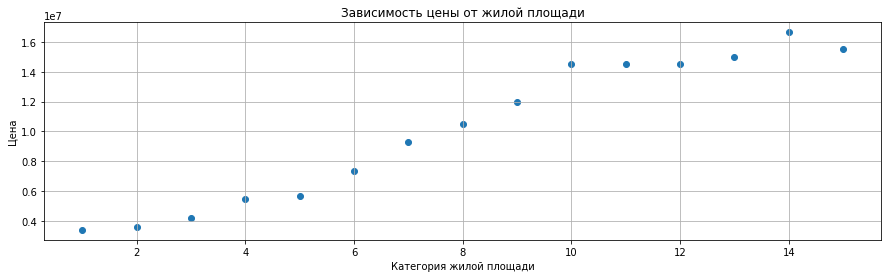

In [ ]:
plt.figure(figsize=(15, 4))
plt.xlabel('Категория жилой площади')
plt.ylabel('Цена')
plt.title('Зависимость цены от жилой площади')
plt.scatter(x=living_stat.index, y=living_stat['last_price'])
plt.grid(True)

In [ ]:
round(data['living_area'].corr(data['last_price']), 2)

0.64

Для жилой площади мы наблюдаем линейную зависимость только при переходе от 2 категории к 10. В начале же и в конце можно говорить о некотором постоянстве цены с ростом площади.

Аналогично предидущему случаю мы получили коэффициент корреляции меньший, чем в первом случае, но достаточный, чтобы говорить о наличии линейной зависимости в той или иной мере.

Таким образом, мы получили, что в целом цена на квартиру линейно возрастает с ростом общей ее площади. Однако о ткаой же зависимости нельзя говорить в случаях площадей кухни и жилой площади.

In [ ]:
#Last_price(rooms)
rooms_stat = data.pivot_table(index='rooms', values='last_price')
rooms_stat

,last_price
rooms,
0,2.964825e+06
1,3.805775e+06
2,5.405722e+06
3,7.318488e+06
4,1.005194e+07
5,1.242737e+07
6,1.430553e+07
7,1.873000e+07


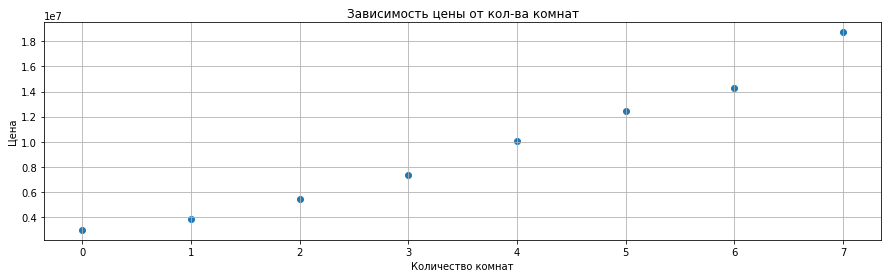

In [ ]:
plt.figure(figsize=(15, 4))
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Зависимость цены от кол-ва комнат')
plt.scatter(x=rooms_stat.index, y=rooms_stat['last_price'])
plt.grid(True)

In [ ]:
round(data['rooms'].corr(data['last_price']), 2)

0.49

При визуальном анализе графика можно сделать вывод, что цена прямо пропорционально зависит от количества комнат, однако по полученному коэффициенту корреляции можно сказать о наличии более сложных зависимостей.

In [ ]:
#Last_price(floor_type)
floor_stat = data.pivot_table(index='floor_type', values='last_price')
floor_stat

,last_price
floor_type,
Другой,5.848439e+06
Первый,4.491496e+06
Последний,5.349191e+06


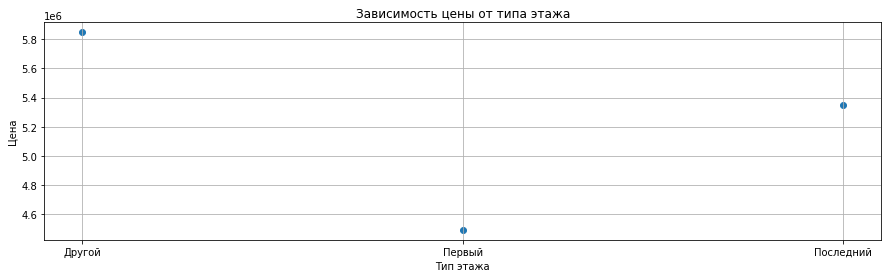

In [ ]:
plt.figure(figsize=(15, 4))
plt.xlabel('Тип этажа')
plt.ylabel('Цена')
plt.title('Зависимость цены от типа этажа')
plt.scatter(x=floor_stat.index, y=floor_stat['last_price'])
plt.grid(True)

По построенному графику можно сделать ввод, что самые дешевые квартиры располагаются на первом этаже, а самые дорогие на других этажах. То есть можно сделать вывод, что покупая квартиры люди предпочитают не жить на 1 и последнем этажах.

Text(0.5, 1.0, 'Зависимость цены от месяца')

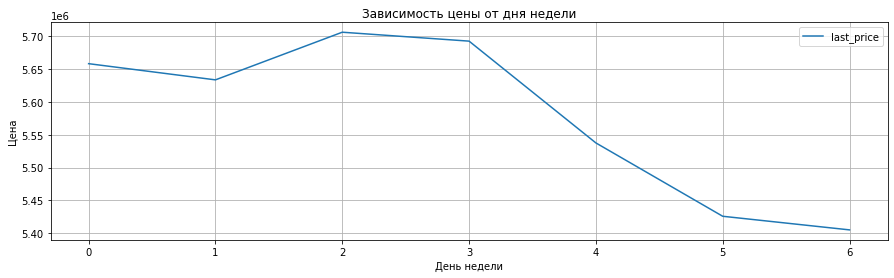

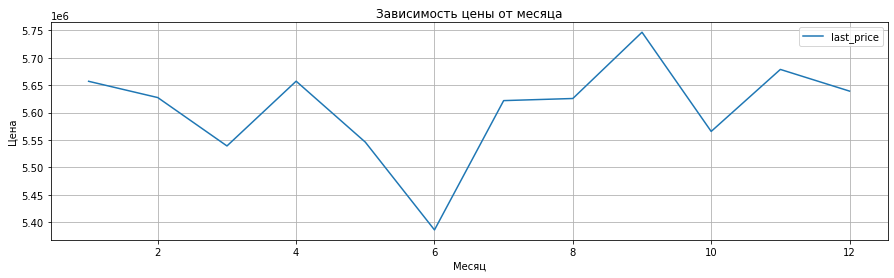

In [ ]:
date_stat = data.pivot_table(index='week_day', values='last_price')
date_stat.plot(y='last_price', grid=True, figsize=(15, 4))
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.title('Зависимость цены от дня недели')
date_stat = data.pivot_table(index='exposition_month', values='last_price')
date_stat.plot(y='last_price', grid=True, figsize=(15, 4))
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.title('Зависимость цены от месяца')

Text(0.5, 1.0, 'Зависимость цены от года')

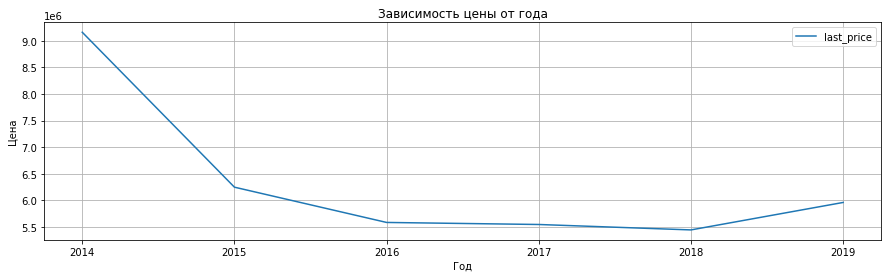

In [ ]:
date_stat = data.pivot_table(index='exposition_year', values='last_price')
date_stat.plot(y='last_price', grid=True, figsize=(15, 4))
plt.xlabel('Год')
plt.ylabel('Цена')
plt.title('Зависимость цены от года')

Text(0.5, 1.0, 'Зависимость суммарной площади от года')

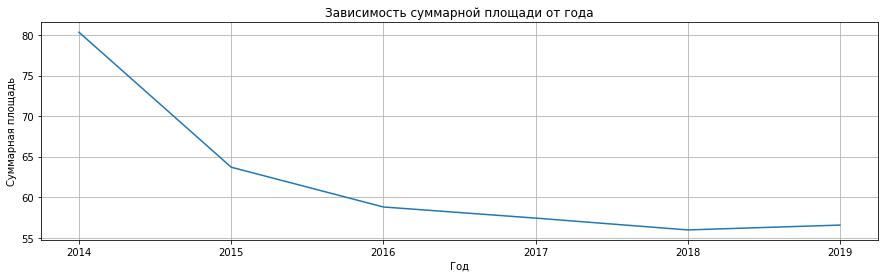

In [ ]:
total_area_year_stat = data.groupby('exposition_year')['total_area'].mean()
total_area_year_stat.plot(y='total_area', grid=True, figsize=(15, 4))
plt.xlabel('Год')
plt.ylabel('Суммарная площадь')
plt.title('Зависимость суммарной площади от года')

Text(0.5, 1.0, 'Зависимость кол-ва объявлений от года')

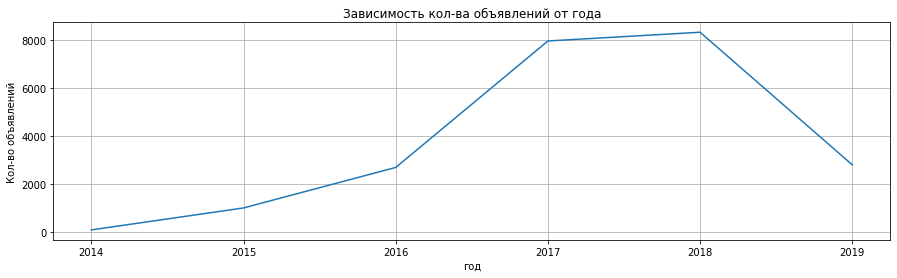

In [ ]:
total_area_year_stat = data.groupby('exposition_year')['locality'].count()
total_area_year_stat.plot(y='locality', grid=True, figsize=(15, 4))
plt.xlabel('год')
plt.ylabel('Кол-во объявлений')
plt.title('Зависимость кол-ва объявлений от года')

По представленным графикам можно заметить, что не прослеживается никакой зависимости между днем недели или месяцем публикации и ценой квартиры, а вот на графике, отражающем цену за разные годы видна тенденция к снижению цен на квартиры с 2014 года по 2018. После 2018 года вновь наблюдается небольшой рост цен, достигая показателей 2017 года.

Для объяснения такиого поведения графика мы построили зависимости средней суммарной площади и количества выставленных объявлений от года. В результате получили, что следом за снижением средней суммарной площади от года к году снижалась и средняя стоимость квартир. Подтвержено зависимостью цены от суммарной площади. Также снижение стоимости жилья связано с возрастанием конкуренции на рынке (ростом количества объявлений).

#### Исследование стоимости 1 кв.м. в разных населенных пунктах

Населённые пункты с самой высокой стоимостью квадратного метра: 
 ['Зеленогорск' 'Лисий Нос' 'Санкт-Петербург' 'Репино' 'Пушкин'] 

Населённые пункты с самой низкой стоимостью квадратного метра: 
 ['Совхозный' 'Выскатка' 'Свирь' 'Старополье' 'Вахнова Кара'] 

Средняя цена за квадратный метр в 10 населённых пунктах с наибольшим числом объявлений:  locality
Санкт-Петербург    110198.777493
Мурино              85837.559158
Кудрово             95110.583500
Шушары              78224.200997
Всеволожск          68605.245736
Пушкин             102858.035366
Колпино             75281.769251
Парголово           90182.083743
Гатчина             68625.141404
Выборг              57922.021272
Name: sq_m_price, dtype: float64


<AxesSubplot:ylabel='locality'>

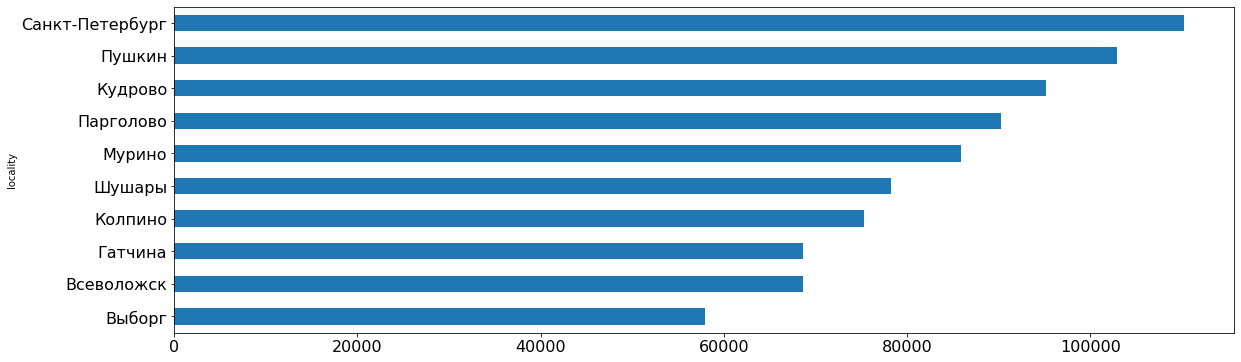

In [ ]:
sq_m_biggest_ads = data.groupby('locality')['sq_m_price'].count()
sq_m_avg_price = data.groupby('locality')['sq_m_price'].mean()
df = pd.concat([sq_m_biggest_ads, sq_m_avg_price], axis=1)
df.columns = ['ads_number', 'sq_m_price']

print('Населённые пункты с самой высокой стоимостью квадратного метра: \n',
      df['sq_m_price'].sort_values(ascending=False).head(5).index.values,
      '\n'
     )
print('Населённые пункты с самой низкой стоимостью квадратного метра: \n',
      df['sq_m_price'].sort_values(ascending=False).tail(5).index.values,
      '\n'
     )
df = df.sort_values(by='ads_number', ascending=False)['sq_m_price'].head(10)
print('Средняя цена за квадратный метр в 10 населённых пунктах с наибольшим числом объявлений: ',
      df
     )

df.sort_values().plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)

Как мы можем заметить, наибольшее число объявлений о продаже квартир характерно для Санкт-Петербурга, также, как и саммая высокая цена за квадратный метр.

#### Исследование зависимости стоимости квартиры от расстояния до центра

Text(0.5, 1.0, 'Расстояние до центра, км')

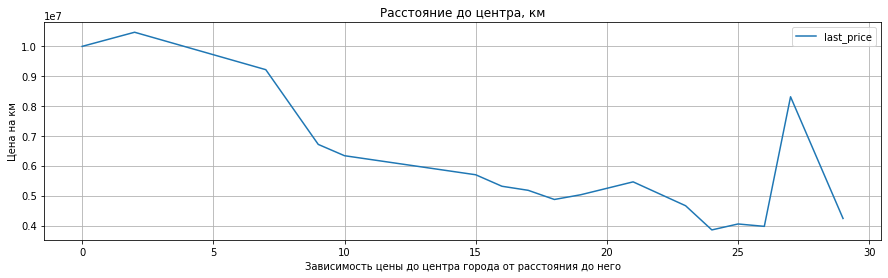

In [ ]:
warnings.filterwarnings("ignore")
snt_pt_stat = data.loc[data['locality'] == 'Санкт-Петербург']
snt_pt_stat['last_price'] = snt_pt_stat.groupby('city_centers_nearest_km')['last_price'].mean()
snt_pt_stat.plot(y='last_price', figsize=(15, 4), grid=True)
plt.xlabel('Зависимость цены до центра города от расстояния до него')
plt.ylabel('Цена на км')
plt.title('Расстояние до центра, км')

In [ ]:
snt_pt_stat = (data.loc[(data['locality'] == 'Санкт-Петербург')
          & (snt_pt_stat['city_centers_nearest_km'] > 26)
          , ['city_centers_nearest_km', 'last_price']]
)
snt_pt_stat['last_price'] /= 1000000
snt_pt_stat.sort_values(by='city_centers_nearest_km')

,city_centers_nearest_km,last_price
748,27.0,14.350
5961,27.0,2.250
814,28.0,7.600
1111,28.0,4.072
9572,28.0,3.413
17798,28.0,4.990
18941,28.0,3.666
22916,28.0,5.144
23145,28.0,6.300
10798,29.0,4.850


In [ ]:
data = data.drop(748)

Text(0.5, 1.0, 'Расстояние до центра, км')

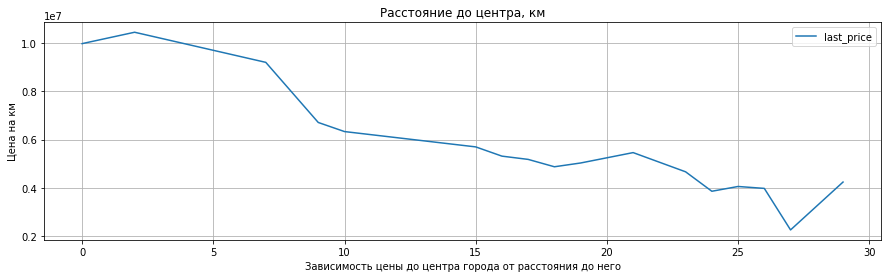

In [ ]:
snt_pt_stat = data.loc[data['locality'] == 'Санкт-Петербург']
snt_pt_stat['last_price'] = snt_pt_stat.groupby('city_centers_nearest_km')['last_price'].mean()
snt_pt_stat.plot(y='last_price', figsize=(15, 4), grid=True)
plt.xlabel('Зависимость цены до центра города от расстояния до него')
plt.ylabel('Цена на км')
plt.title('Расстояние до центра, км')

Выведя график зависимости средней стоимости квартиры в Санкт-Петербурге от расстояния до центра мы получили следующие результаты. В масштабах всего графика значения стоимости квартир на расстоянии до 5 км можно считать примерно одинаковыми, однако цена за квартиры находящиеся непосредственно в центре и на удалении 5 км от него чуть ниже цен на квартиры, находящиеся на удалении 2-3 км от центра. Данный факт можно объяснить тем, что квартиры на расстоянии 2-3 км считаются самыми удобными за счет хорошей окружающей инфраструктуры, ее доступности и невысокого уровня шума, относительно  центра.

Далее от 5 до 20 км мы наблюдаем снижение стоимости, что вполне логично. В диапазоне 21 - 23 км мы наблюдаем небольшой скачок стоимости, который может быть объяснен наличием нового, хорошо благоустроенного района и как следствие несколько более высокими ценами на жилье, хоть и находится от центра дальше. В добавок квартиры в этом диапазоне расстояний могут находится близ метро.

В диапазоне 26 - 28 км мы наблюдаем резкий скачок стоимости, что не характерно для нашей заисимости. В рамках исследования такого анмального поведения нашего графика выведем квартиры, находящиеся на расстоянии, большем 26 км. Заметим, что скачок находится на расстоянии 27 км из-за наличия там только 2 данных, одно из которых можно считать аномально бальшим и как следствие отбросим его.

Выведем зависимость заново, чтобы убедится, что выброс был только на 27 км. На графике образовался провал, который можно объяснить тем, что на этом км продается только одна квартира, о которой невозможно составить достоверную статистику.

last_price
city_centers_nearest_km floor_type            
0.0                     Другой               8
                        Первый               2
                        Последний            2
1.0                     Другой             102
                        Первый              21
...                                        ...
24.0                    Первый               1
                        Последний            1
25.0                    Другой              20
                        Первый               5
                        Последний            1

[78 rows x 1 columns]

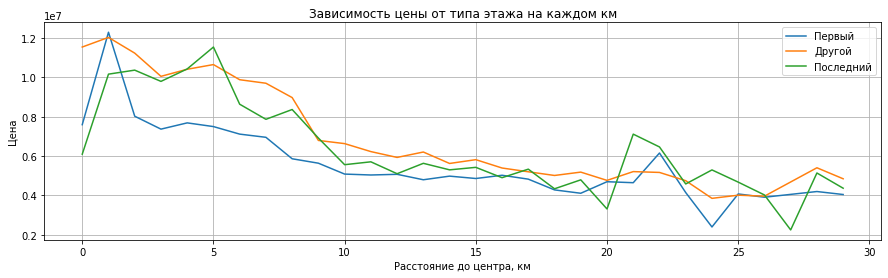

In [ ]:
floor_type_km_stat = data.loc[data['locality'] == 'Санкт-Петербург', ['last_price', 'city_centers_nearest_km', 'floor_type']]

floor_type_km_stat1 = (floor_type_km_stat[floor_type_km_stat['floor_type'] == 'Первый']
                       .groupby('city_centers_nearest_km')
                       .mean()
                      )
floor_type_km_stat2 = (floor_type_km_stat[floor_type_km_stat['floor_type'] == 'Другой']
                       .groupby('city_centers_nearest_km')
                       .mean()
                      )
floor_type_km_stat3 = (floor_type_km_stat[floor_type_km_stat['floor_type'] == 'Последний']
                       .groupby('city_centers_nearest_km')
                       .mean()
                      )

plt.figure(figsize=(15, 4))
plt.grid(True)
plt.plot(floor_type_km_stat1)
plt.plot(floor_type_km_stat2)
plt.plot(floor_type_km_stat3)
plt.legend(['Первый', 'Другой', 'Последний'])
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Цена')
plt.title('Зависимость цены от типа этажа на каждом км')

group_stat = floor_type_km_stat.groupby(['city_centers_nearest_km', 'floor_type'])['last_price'].count().to_frame()
group_stat.loc[:25, :]

Также проанализируем распределение цен за квартиры в Санкт-Петербурге в зависимости от типа этажа. Так, наблюдаем, что в диапазоне между8 км 20 км почти всегда цена на квартиры на первом этаже меньше, чем на квартиры на последнем этаже, которые в свою очередь дешевле квартир на других этажах. На остальных уччастках сложно определить зависимости.

Однако можно объяснить по этому графику мы можем увидеть, что стоимость квартир на других этажах на 3 км выше остальных, а по вывекденной таблице видно, что на этом же км таких квартир больше всего. Это объясняет небольшой подъем цены преидущего графика по сранению со 2 и 4 км.

In [ ]:
# check
group_stat.loc[3:5]

last_price
city_centers_nearest_km floor_type            
3.0                     Другой             193
                        Первый              53
                        Последний           73
4.0                     Другой             441
                        Первый              77
                        Последний          102
5.0                     Другой             608
                        Первый              76
                        Последний          123

### Общий вывод

В рамках данного проекта был обработан набор входных данных. Посдле изучения данных, были обработаны пропуски и аномальные значения. Все данные были преобразованы к необходимому типу для удобства последующего анализа. Затем были устранены неявные дубликаты в названиях населенных пунктов.

В рамках анализа данных также было обнаружено, что стоимость квартиры зависит от набора параметров целиком, хотя можно проследить и частные зависимости. Так для цена квартиры линейно зависит от суммарной площади квартиры и менее линейно зависит от количества комнат.

Помимо этого для предоставленного набора данных были исследованы зависимости и тенденции в течении нескольких лет и было замечена, что стоимость квартир с 2014 года падала вплоть до начала 2018, нок началу 2019 вернулась к состоянию на начало 2017 года.

Также можно сказать, что начиная с 2014 года и вплоть до конца 2017 на рынке недвижимости росла конкуренция, так как росло количество объявлений, но в течение 2018 года наблюдался небольшой спад.

Кроме того для квартир в Санкт-Петербурге была прослежена тенденция к снижению стоимости за квартиру при удалении от центра города.